# Local Measures of Spatial Autocorrelation

In [6]:
# Load relevant R packages
inLibraries = list('rgdal','spdep','classInt','rgeos','repr')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Crime Analysis

This time, let's look at some crime data. There are a wide variety of sources of crime data that are publically available and easy to access. For instance, I did a websearch for crime data and found the city of Chicago posts current crimes in a .csv file format (Chicago Crime data https://catalog.data.gov/dataset/crimes-one-year-prior-to-present-e171f). There are actually a large amount of crimes in this dataset, so I took a subset (those reported for Oct. 2016). In order to associate a topology with the crime data, I found some US Census Blockgroups for the state of Illinois (https://www.census.gov/geo/maps-data/data/cbf/cbf_blkgrp.html). Next, I created a point featureclass from the .csv file since it contained latitude/longitude fields and associated both the crime and blockgroup features with the same coordinate reference system. Finally, I joined the two datasets such that each blockgroup now has a field containing the number of burglaries in Oct. 2016 (Burglaries) and a field containing the total number of crimes in Oct. 2016 (AllCrime). 

In [7]:
blockGroup <- readOGR("datasets/chicago",
                      "ChicagoBurglaryOct2016")

chiPoly <- readOGR("datasets/chicago",
                      "ChicagoBoundary")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/chicago", layer: "ChicagoBurglaryOct2016"
with 9689 features
It has 13 fields
Integer64 fields read as strings:  TARGET_FID Burglaries AllCrime 
OGR data source with driver: ESRI Shapefile 
Source: "datasets/chicago", layer: "ChicagoBoundary"
with 77 features
It has 9 fields


In [8]:
peekBG <- head(blockGroup@data, 3)

t(peekBG)

,0,1,2
TARGET_FID,0,1,2
STATEFP,17,17,17
COUNTYFP,031,019,031
TRACTCE,010100,005300,811301
BLKGRPCE,3,1,4
AFFGEOID,1500000US170310101003,1500000US170190053001,1500000US170318113014
GEOID,170310101003,170190053001,170318113014
NAME,3,1,4
LSAD,BG,BG,BG
ALAND,133973,3095432,1626156


In [9]:
peekPoly <- head(chiPoly@data)

t(peekPoly)

,0,1,2,3,4,5
perimeter,0,0,0,0,0,0
community,DOUGLAS,OAKLAND,FULLER PARK,GRAND BOULEVARD,KENWOOD,LINCOLN SQUARE
shape_len,31027.05,19565.51,25339.09,28196.84,23325.17,36624.60
shape_area,46004621,16913961,19916705,48492503,29071742,71352328
area,0,0,0,0,0,0
comarea,0,0,0,0,0,0
area_numbe,35,36,37,38,39,4
area_num_1,35,36,37,38,39,4
comarea_id,0,0,0,0,0,0


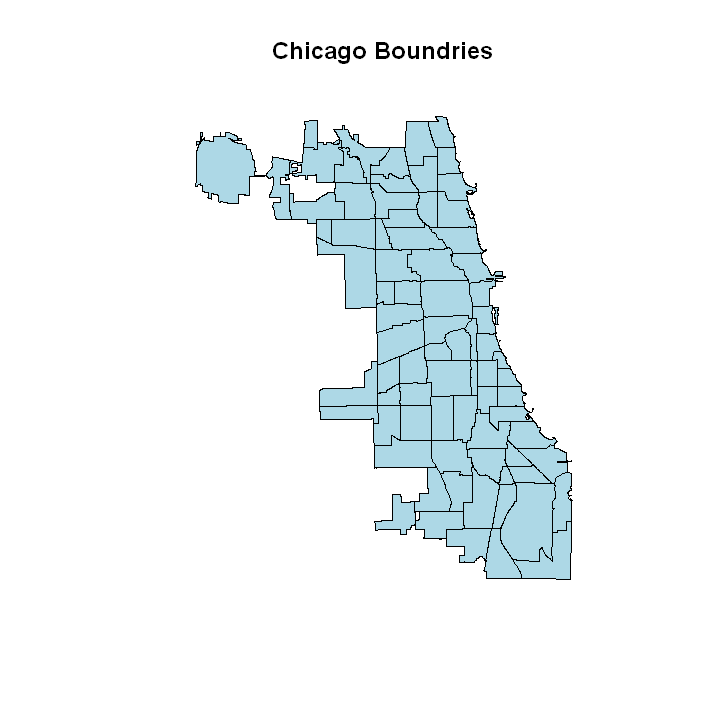

In [10]:
plot(chiPoly, col = "lightblue", lwd = 0.2, main = "Chicago Boundries")

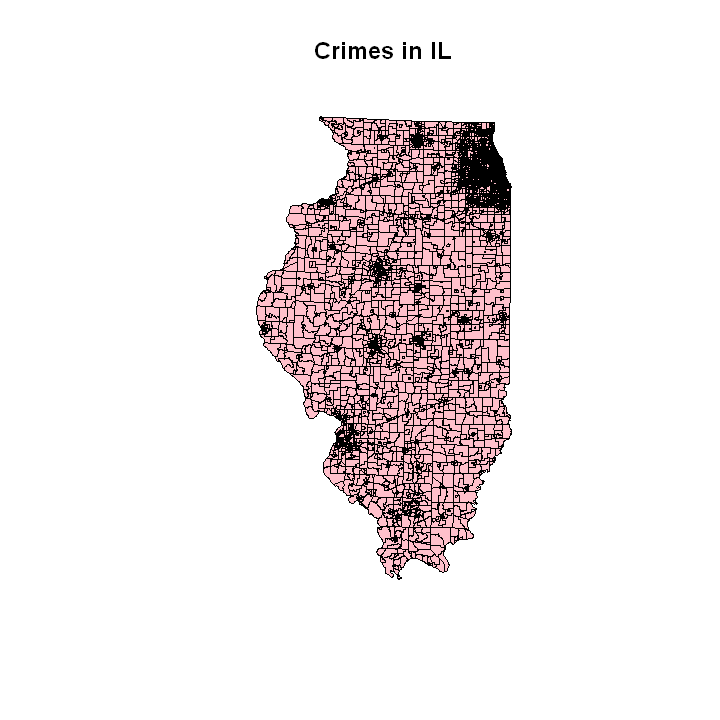

In [11]:
plot(blockGroup, col = "pink", lwd = 0.2, main = "Crimes in IL")

Given that the blockgroup data is for the entire state of Illinois and the crime is only for the Chicago area, you should refine the set of polygons that will be retained for analysis.

In [12]:
selFeat <- overGeomGeom(chiPoly, blockGroup, 
                            returnList =  TRUE, 
                            fn = NULL)

In [13]:
typeof(selFeat)

[1] "list"

In [14]:
intSet <- unlist(selFeat)

In [15]:
print(paste("There are ", length(intSet)," intersecting features"))

[1] "There are  3553  intersecting features"


In [16]:
intFeat <- blockGroup[intSet, ]

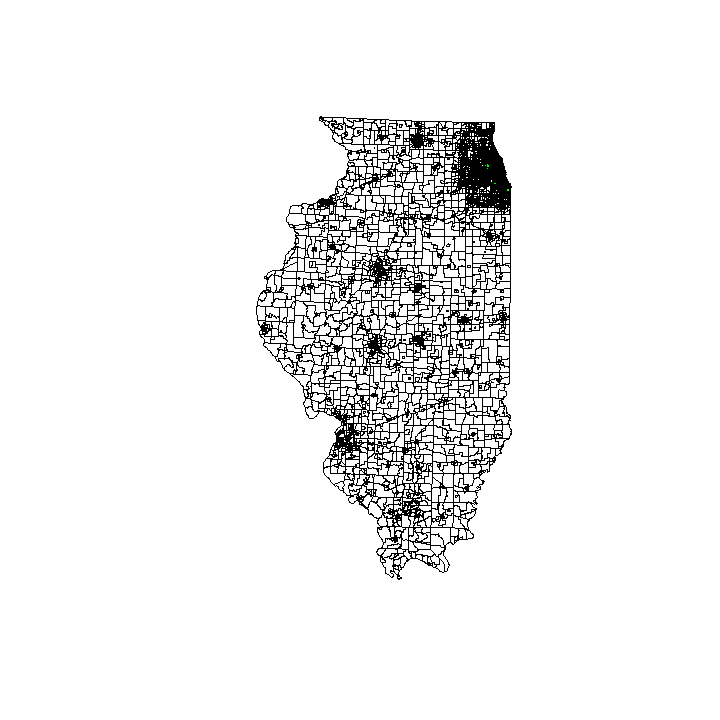

In [17]:
plot(blockGroup, col = "white", lwd = 0.2)
plot(intFeat, add = TRUE, col = "green")

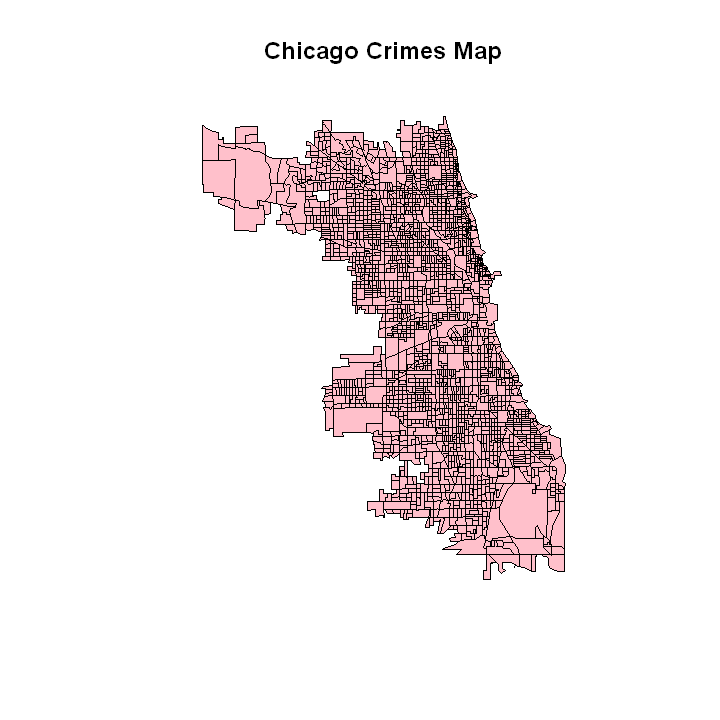

In [18]:
plot(intFeat, col = "pink", lwd = 0.2, main = "Chicago Crimes Map")

Generate a spdep neighborhood object for the selected blockgroups.

In [19]:
chi.nb <- poly2nb(intFeat, queen = TRUE)

chi.nb

Neighbour list object:
Number of regions: 3553 
Number of nonzero links: 46088 
Percentage nonzero weights: 0.3650879 
Average number of links: 12.97157 

In [20]:
head(chi.nb)

[[1]]
[1]  6  7 31 32 33 42 93

[[2]]
 [1]    9   13   20   29   55   76   80  100 1680 1688 1692 1699 2599

[[3]]
 [1]    4    8    9   10   17   20   21   22   25   28   41   72   76   97 1671
[16] 1692

[[4]]
 [1]   3  11  22  28  30  36  41  46  97 103

[[5]]
 [1]   12   15   19   20   23 1653 1664 1667 1672 1683 1685 1689 1692 1694 1700
[16] 2613 2619

[[6]]
 [1]   1   7  11  16  22  30  31  32  33  36  39  41  42  46  47  82  93 103 104

Should a feature have no neighbors, problems may arise in the computation of measures that are premised on the assumption that a valid neighborhood exists for a feature. 

Given this: 

a) check the neighborhoods for features and only retain those features that have a valid neighborhood, 

b) generate the neighborhoods for the areas that have valid neighborhoods again applying the Queen's criterion, and 

c) transform the neighborhoods into neighborhood lists.

In [21]:
length(chi.nb)

[1] 3553

In [22]:
chi.subset <- intFeat[card(chi.nb) >= 1, ]

In [23]:
length(chi.nb)

[1] 3553

In [24]:
chi.subset.nb <- poly2nb(chi.subset, queen = TRUE)

chi.subset.nb

Neighbour list object:
Number of regions: 3553 
Number of nonzero links: 46088 
Percentage nonzero weights: 0.3650879 
Average number of links: 12.97157 

In [25]:
chi.subset.listb <- nb2listw(chi.subset.nb, style = "B")
chi.subset.listw <- nb2listw(chi.subset.nb, style = "W")

In [26]:
names(chi.subset.listb)

[1] "style"      "neighbours" "weights"

In [27]:
head(chi.subset.listb$weights)

[[1]]
[1] 1 1 1 1 1 1 1

[[2]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1

[[3]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

[[4]]
 [1] 1 1 1 1 1 1 1 1 1 1

[[5]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

[[6]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [28]:
head(chi.subset.listw$weights)

[[1]]
[1] 0.1428571 0.1428571 0.1428571 0.1428571 0.1428571 0.1428571 0.1428571

[[2]]
 [1] 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
 [7] 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308 0.07692308
[13] 0.07692308

[[3]]
 [1] 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
[11] 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625

[[4]]
 [1] 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1

[[5]]
 [1] 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 [7] 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
[13] 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353

[[6]]
 [1] 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
 [7] 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
[13] 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158 0.05263158
[19] 0.05263158

Examine burglary 'Burglaries' relative to the total crime 'AllCrime' in each blockgroup. J

In [29]:
head(chi.subset@data, 15)

,TARGET_FID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Burglaries,AllCrime
358,358,17,031,836500,1,1500000US170318365001,170318365001,1,BG,117472,5187,0,7
616,616,17,031,351500,2,1500000US170313515002,170313515002,2,BG,79096,0,0,8
798,798,17,031,839500,1,1500000US170318395001,170318395001,1,BG,262139,0,0,18
865,865,17,031,351100,1,1500000US170313511001,170313511001,1,BG,80349,0,0,0
1169,1169,17,031,350400,1,1500000US170313504001,170313504001,1,BG,201453,0,0,21
1642,1642,17,031,360200,1,1500000US170313602001,170313602001,1,BG,232044,0,0,19
1643,1643,17,031,351000,1,1500000US170313510001,170313510001,1,BG,396703,665632,0,7
1908,1908,17,031,839600,2,1500000US170318396002,170318396002,2,BG,230641,0,0,27
1948,1948,17,031,351400,1,1500000US170313514001,170313514001,1,BG,323957,0,0,10
2103,2103,17,031,350100,1,1500000US170313501001,170313501001,1,BG,291445,518735,0,4


In [44]:
burg <- as.numeric(as.character(chi.subset$Burglaries))

In [45]:
allCrime <- as.numeric(as.character(chi.subset$AllCrime))

In [46]:
burg[1:20]

[1] 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1

In [48]:
# burg rate

burgRate <- (burg / allCrime)

In [49]:
burgRate[1:20]

[1] 0.00000000 0.00000000 0.00000000        NaN 0.00000000 0.00000000
 [7] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.07142857
[13] 0.00000000 0.11111111 0.00000000 0.00000000 0.05555556 0.00000000
[19] 0.00000000 0.12500000

In [50]:
# replace NaNs with 0
burgRate[is.nan(burgRate)] <- 0

In [51]:
burgRate[1:20]

[1] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000
 [7] 0.00000000 0.00000000 0.00000000 0.00000000 0.00000000 0.07142857
[13] 0.00000000 0.11111111 0.00000000 0.00000000 0.05555556 0.00000000
[19] 0.00000000 0.12500000

Classify the analysis variable into five categories using the Jenks optimization method. 

In [53]:
numcat <- 5

cate <- classIntervals(burgRate, numcat, style = "jenks")
cate

style: jenks
  one of 3,612,280 possible partitions of this variable into 5 classes
  [0,0.06451613] (0.06451613,0.2]        (0.2,0.4]  (0.4,0.6666667] 
            2523              692              266               61 
   (0.6666667,1] 
              11 

In [54]:
pal <- gray.colors(numcat)
cols <- findColours(cate, pal)

In [55]:
pal

[1] "#4D4D4D" "#888888" "#AEAEAE" "#CCCCCC" "#E6E6E6"

In [56]:
cols[1:20]

[1] "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D"
 [8] "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#888888" "#4D4D4D" "#888888"
[15] "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#888888"

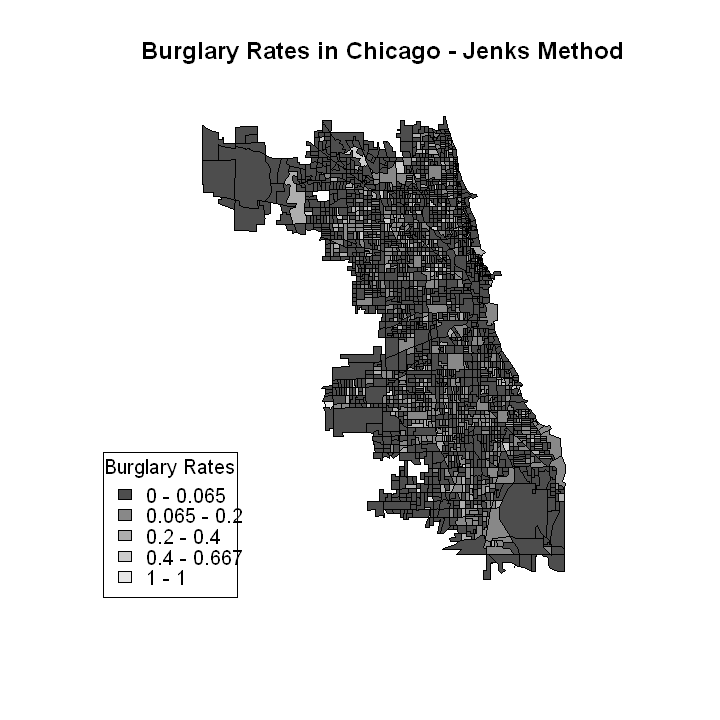

In [57]:
plot(chi.subset, col = cols, lwd = 0.2, main = "Burglary Rates in Chicago - Jenks Method")

# legend settings

brks <- round(cate$brks, 3)
leg.text <- paste(brks[-numcat], brks[-1], sep = " - ")
legend("bottomleft", fill = attr(cols, "palette"), legend = leg.text, title = "Burglary Rates")

Compute the local Moran statistic for the two.sided hypothesis. 

In [58]:
LM <- localmoran(burgRate, chi.subset.listw, alternative = "two.sided")

head(LM)

,Ii,E.Ii,Var.Ii,Z.Ii,Pr(z != 0)
358,0.2625551,-0.0002815315,0.14197034,0.6975688,0.4854469
616,0.1817098,-0.0002815315,0.07631677,0.6587804,0.5100368
798,0.1822712,-0.0002815315,0.06195505,0.7334154,0.4633051
865,0.2625551,-0.0002815315,0.09929552,0.8341056,0.4042215
1169,0.1204428,-0.0002815315,0.05829422,0.5000137,0.6170654
1642,0.2204102,-0.0002815315,0.05212862,0.9666025,0.3337428


In [59]:
zScore <- LM[, c("Z.Ii")]

pValue <- LM[, c("Pr(z != 0)")]

In [60]:
zScore[1:5]

358       616       798       865      1169 
0.6975688 0.6587804 0.7334154 0.8341056 0.5000137

In [61]:
pValue[1:5]

358       616       798       865      1169 
0.4854469 0.5100368 0.4633051 0.4042215 0.6170654

The Gi* statistic can be employed in instances where the neighborhood of a feature includes the feature itself. 

In [62]:
chi.subset.nb[1:5]

[[1]]
[1]  6  7 31 32 33 42 93

[[2]]
 [1]    9   13   20   29   55   76   80  100 1680 1688 1692 1699 2599

[[3]]
 [1]    4    8    9   10   17   20   21   22   25   28   41   72   76   97 1671
[16] 1692

[[4]]
 [1]   3  11  22  28  30  36  41  46  97 103

[[5]]
 [1]   12   15   19   20   23 1653 1664 1667 1672 1683 1685 1689 1692 1694 1700
[16] 2613 2619

In [63]:
chi.subset.self <- include.self(chi.subset.nb)

In [64]:
chi.subset.self[1:5]

[[1]]
[1]  1  6  7 31 32 33 42 93

[[2]]
 [1]    2    9   13   20   29   55   76   80  100 1680 1688 1692 1699 2599

[[3]]
 [1]    3    4    8    9   10   17   20   21   22   25   28   41   72   76   97
[16] 1671 1692

[[4]]
 [1]   3   4  11  22  28  30  36  41  46  97 103

[[5]]
 [1]    5   12   15   19   20   23 1653 1664 1667 1672 1683 1685 1689 1692 1694
[16] 1700 2613 2619

In [65]:
# B weights with self

chi.subset.self.listb <- nb2listw(chi.subset.self, style = "B")
chi.subset.self.listw <- nb2listw(chi.subset.self, style = "W")

In [66]:
head(chi.subset.self.listb$weights)

[[1]]
[1] 1 1 1 1 1 1 1 1

[[2]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1

[[3]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

[[4]]
 [1] 1 1 1 1 1 1 1 1 1 1 1

[[5]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

[[6]]
 [1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [67]:
head(chi.subset.self.listw$weights)

[[1]]
[1] 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125

[[2]]
 [1] 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 [7] 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
[13] 0.07142857 0.07142857

[[3]]
 [1] 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
 [7] 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353
[13] 0.05882353 0.05882353 0.05882353 0.05882353 0.05882353

[[4]]
 [1] 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 [7] 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909

[[5]]
 [1] 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
 [7] 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556
[13] 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556 0.05555556

[[6]]
 [1] 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
[16] 0.05 0.05 0.05 0.05 0.05

Calculate the local Gi* statistic using the burglary rate variable created earlier.

In [68]:
g <- localG(burgRate, chi.subset.self.listb)

head(g)

[1] -1.450720 -1.371561 -1.508071 -1.701840 -1.065179 -1.947303

Compute the z-scores associated with the 0.90, 0.95, and 0.995 confidence levels assuming a normal distribution. 

In [69]:
zNormal <- list()

probsU <- c(0.90, 0.95, 0.99)

i <- 1

for (pr in probsU){
    # convert confidence levels to sig probs
    inpr <- 1 - ((1-pr)/2)
    
    # compute normal error for z-score
    errorZ <- qnorm(inpr, lower.tail = TRUE)
    zNormal[[i]] <- 0 + errorZ
    i <- i + 1
}

In [70]:
zG <- unlist(zNormal)

In [71]:
paste(probsU, zG, sep = " => ")

[1] "0.9 => 1.64485362695147"  "0.95 => 1.95996398454005"
[3] "0.99 => 2.5758293035489"

Map the normal distribution z-scores based on the three confidence level intervals for the Moran statistic. 

In [72]:
ncz1 <- 4 + length(zG) - 1
ncz2 <- 4 + length(zG)

In [73]:
z.Mi <- classIntervals(zScore, n = ncz1, style = "fixed", fixedBreaks = c(min(zScore), -zG, zG, max(zScore)))

In [74]:
z.Mi

style: fixed
[-11.86356,-2.575829) [-2.575829,-1.959964) [-1.959964,-1.644854) 
                   28                    35                    36 
 [-1.644854,1.644854)   [1.644854,1.959964)   [1.959964,2.575829) 
                 3263                    20                    51 
  [2.575829,41.29237] 
                  120 

In [75]:
pal <- c("black", "blue", "lightblue", "white", "pink", "red", "red4")
cols.m <- findColours(z.Mi, pal)

In [76]:
pal

[1] "black"     "blue"      "lightblue" "white"     "pink"      "red"      
[7] "red4"

In [77]:
cols.m[1:20]

[1] "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF"
 [8] "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF"
[15] "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF" "#FFFFFF"

In [78]:
length(cols.m)

[1] 3553

In [79]:
length(zScore)

[1] 3553

In [80]:
length(chi.subset)

[1] 3553

In [81]:
head(chi.subset@data)

,TARGET_FID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Burglaries,AllCrime
358,358,17,031,836500,1,1500000US170318365001,170318365001,1,BG,117472,5187,0,7
616,616,17,031,351500,2,1500000US170313515002,170313515002,2,BG,79096,0,0,8
798,798,17,031,839500,1,1500000US170318395001,170318395001,1,BG,262139,0,0,18
865,865,17,031,351100,1,1500000US170313511001,170313511001,1,BG,80349,0,0,0
1169,1169,17,031,350400,1,1500000US170313504001,170313504001,1,BG,201453,0,0,21
1642,1642,17,031,360200,1,1500000US170313602001,170313602001,1,BG,232044,0,0,19


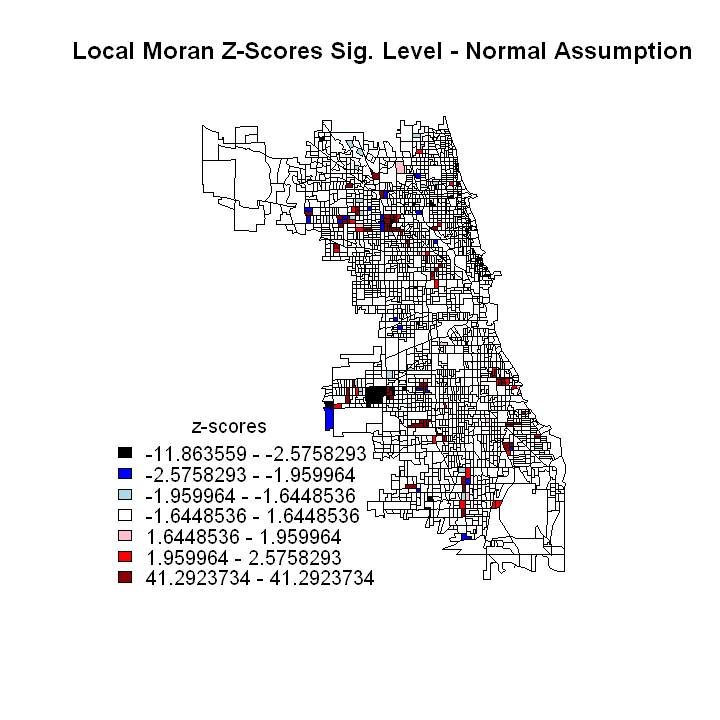

In [82]:
plot(chi.subset, col = cols.m, lwd = 0.2, main = "Local Moran Z-Scores Sig. Level - Normal Assumption")
brks <- round(z.Mi$brks, ncz2)
leg <- paste(brks[-ncz2], brks[-1], sep = " - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "z-scores")

Map the normal distribution z-scores based on the three confidence level intervals for the G statistic. 

In [83]:
ncz1 <- 4 + length(zG) - 1
ncz2 <- 4 + length(zG)

In [84]:
print(ncz1)

[1] 6


In [85]:
print(ncz2)

[1] 7


In [86]:
z.Gi <- classIntervals(g, n = ncz1, style = "fixed", fixedBreaks = c(min(g), -zG, zG, max(g)))

In [87]:
z.Gi

style: fixed
[-2.575829,-2.465036) [-2.465036,-1.959964) [-1.959964,-1.644854) 
                    0                    67                   202 
 [-1.644854,1.644854)   [1.644854,1.959964)   [1.959964,2.575829) 
                 2837                    79                   141 
  [2.575829,8.853774] 
                  227 

In [88]:
pal <- c("black", "blue", "lightblue", "white", "pink", "red", "red4")
cols.g <- findColours(z.Gi, pal)

In [89]:
pal

[1] "black"     "blue"      "lightblue" "white"     "pink"      "red"      
[7] "red4"

In [90]:
cols.g[1:10]

[1] "#FFFFFF" "#FFFFFF" "#FFFFFF" "#ADD8E6" "#FFFFFF" "#ADD8E6" "#ADD8E6"
 [8] "#ADD8E6" "#FFFFFF" "#FFFFFF"

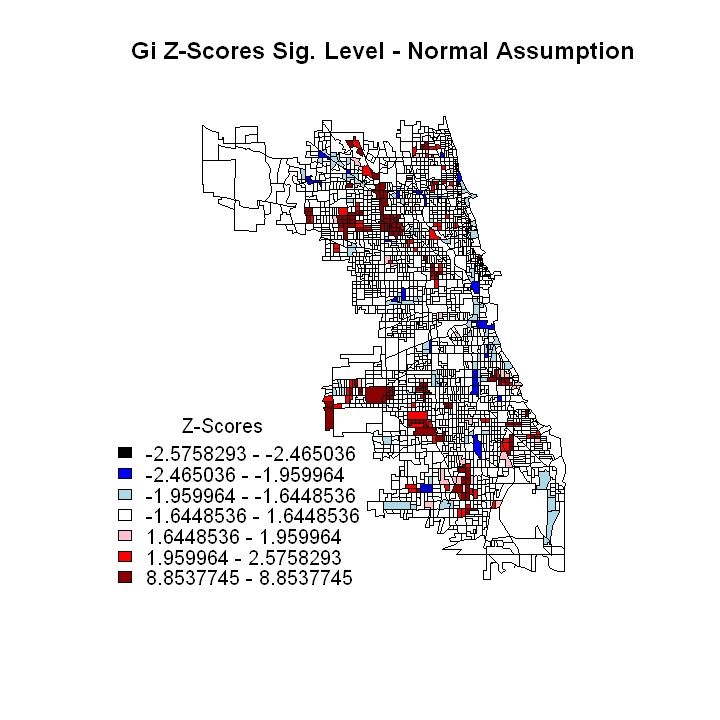

In [91]:
plot(chi.subset, col = cols.g, lwd = 0.2, main = "Gi Z-Scores Sig. Level - Normal Assumption")

brks <- round(z.Gi$brks, ncz2)
leg <- paste(brks[-ncz2], brks[-1], sep = " - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "Z-Scores")

Compute the Effective Sample Size (ESS) of this dataset.

In [92]:
dsar <- errorsarlm(burgRate ~1, listw = chi.subset.listw)

In [93]:
dsar


Call:
errorsarlm(formula = burgRate ~ 1, listw = chi.subset.listw)
Type: error 

Coefficients:
     lambda (Intercept) 
 0.30983046  0.06228591 

Log likelihood: 2486.225 

In [94]:
rho <- dsar$lambda
rho

lambda 
0.3098305

In [95]:
rho2 <- unname(rho)
rho2

[1] 0.3098305

In [96]:
dvalues <- length(chi.subset)
paste("Number of polygons: ", dvalues)

[1] "Number of polygons:  3553"

In [97]:
ESS <- dvalues * (1-(1/(1-exp(-1.92349)))*((dvalues-1)/dvalues)*(1-exp((-2.12373*rho2)+ (.20024*sqrt(rho2)))))
paste("ESS: ", ESS)

[1] "ESS:  1801.55348398613"

Compute the normal adjusted z-scores associated with the 0.90, 0.95, and 0.995 confidence levels. 

In [98]:
zAdjusted <- list()

probsU <- c(0.90, 0.95, 0.995)

i <- 1
for (pr in probsU){
    rmean <- mean(burgRate)
    newpr <- 1 - (((1 - pr)/ESS)/2)
    
    errorN <- qnorm(newpr, mean = rmean, lower.tail = TRUE)
    zAdjusted[[i]] <- 0 + errorN
    i <- i + 1
}

In [99]:
zcG <- unlist(zAdjusted)

In [100]:
paste(probsU, zcG, sep = " | ")

[1] "0.9 | 4.09359139993924"   "0.95 | 4.25360906212733" 
[3] "0.995 | 4.74923339091407"

Produce a map of the normally adjusted z-scores for the Gi* statistic.

In [101]:
nczc1 <- 4 + length(zcG) - 1
nczc2 <- 4 + length(zcG)

In [102]:
z.Gi <- classIntervals(g, n = nczc1, style = "fixed", fixedBreaks = c(min(g), -zcG, zcG, max(g)))

z.Gi

style: fixed
[-4.749233,-4.253609) [-4.253609,-4.093591) [-4.093591,-2.465036) 
                    0                     0                     0 
 [-2.465036,4.093591)   [4.093591,4.253609)   [4.253609,4.749233) 
                 3486                     5                    16 
  [4.749233,8.853774] 
                   46 

In [103]:
pal <- c("black", "blue", "lightblue", "white", "pink", "red", "red4")
cols.g <- findColours(z.Gi, pal)

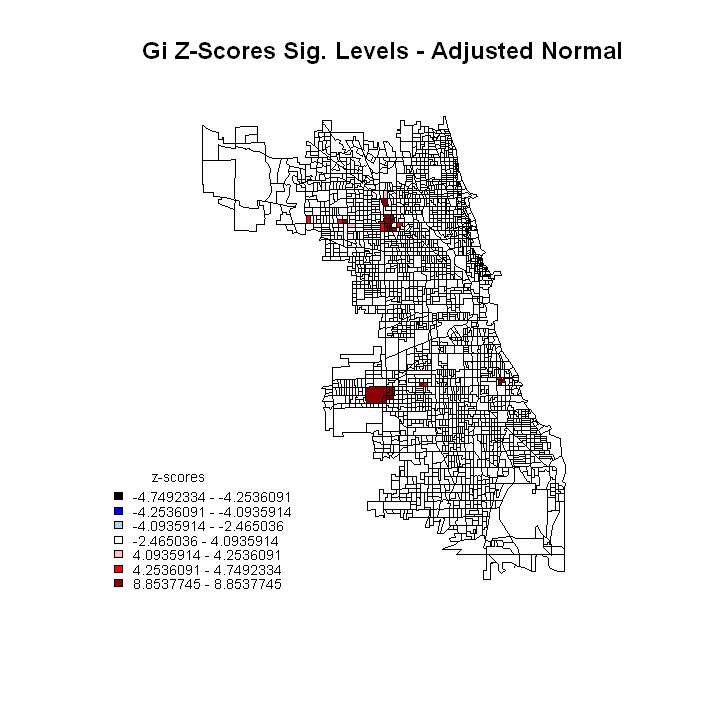

In [104]:
plot(chi.subset, col = cols.g, lwd = 0.2, main = "Gi Z-Scores Sig. Levels - Adjusted Normal")
brks <- round(z.Gi$brks, nczc2)
leg <- paste(brks[-nczc2], brks[-1], sep = " - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "z-scores", cex = 0.7)

Produce a map of the normally adjusted z-scores for the Moran statistic.

In [105]:
nczc1 <- 4 + length(zcG) - 1
nczc2 <- 4 + length(zcG)

In [106]:
z.Mi <- classIntervals(zScore, n = nczc1, style = "fixed", fixedBreaks = c(min(zScore), -zcG, zcG, max(zScore)))

z.Mi

style: fixed
[-11.86356,-4.749233) [-4.749233,-4.253609) [-4.253609,-4.093591) 
                    7                     2                     1 
 [-4.093591,4.093591)   [4.093591,4.253609)   [4.253609,4.749233) 
                 3466                     1                     7 
  [4.749233,41.29237] 
                   69 

In [107]:
pal <- c("black", "blue", "lightblue", "white", "pink", "red", "red4")
cols.m <- findColours(z.Mi, pal)

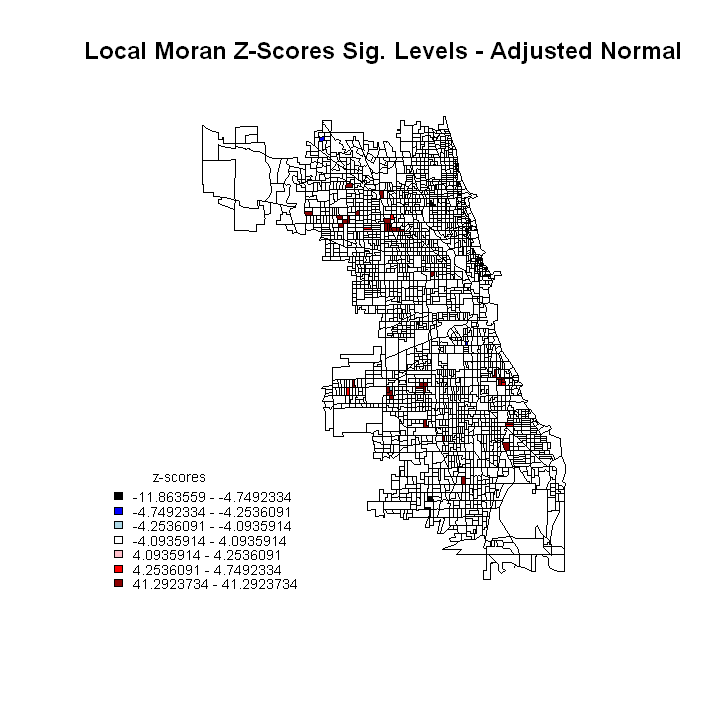

In [108]:
plot(chi.subset, col = cols.m, lwd = 0.2, main = "Local Moran Z-Scores Sig. Levels - Adjusted Normal")
brks <- round(z.Mi$brks, nczc2)
leg <- paste(brks[-nczc2], brks[-1], sep=" - ")
legend("bottomleft", fill = pal, legend = leg, bty = "n", title = "z-scores", cex = 0.7)

Computing difference in significance - Produce a map that shows blockgroups that were significant at the 0.90 confidence level under the normal distribution that were not signficant at the 0.90 confidence level under the adjusted normal distribution.

In [109]:
dim(chi.subset@data)

[1] 3553   13

In [110]:
# calculate normal colors. append them to the chicago dataset

zNormal <- list()

probsU <- c(0.90)

i <- 1

for (pr in probsU){
    # convert confidence levels to sig probs
    inpr <- 1 - ((1-pr)/2)
    
    # compute normal error for z-score
    errorZ <- qnorm(inpr, lower.tail = TRUE)
    zNormal[[i]] <- 0 + errorZ
    i <- i + 1
}

zG <- unlist(zNormal)
paste(probsU, zG, sep = " => ")

[1] "0.9 => 1.64485362695147"

In [111]:
ncz1 <- 4 + length(zG) - 1
ncz2 <- 4 + length(zG)

z.Gi <- classIntervals(g, n = ncz1, style = "fixed", fixedBreaks = c(min(g), -zG, zG, max(g)))
pal <- c("black", "white", "red")
cols.g <- findColours(z.Gi, pal)

In [112]:
z.Gi

style: fixed
[-2.465036,-1.644854)  [-1.644854,1.644854)   [1.644854,8.853774] 
                  269                  2837                   447 

In [113]:
unique(cols.g)

[1] "#FFFFFF" "#000000" "#FF0000"

In [114]:
chi.subset$gScore <- g

In [115]:
chi.subset$NormalColor <- cols.g

In [116]:
chi.subset$isSignificant_Normal <- ifelse(chi.subset$NormalColor == "#FFFFFF", 0, 1)

In [117]:
head(chi.subset@data, 5)

,TARGET_FID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Burglaries,AllCrime,gScore,NormalColor,isSignificant_Normal
358,358,17,031,836500,1,1500000US170318365001,170318365001,1,BG,117472,5187,0,7,-1.450720,#FFFFFF,0
616,616,17,031,351500,2,1500000US170313515002,170313515002,2,BG,79096,0,0,8,-1.371561,#FFFFFF,0
798,798,17,031,839500,1,1500000US170318395001,170318395001,1,BG,262139,0,0,18,-1.508071,#FFFFFF,0
865,865,17,031,351100,1,1500000US170313511001,170313511001,1,BG,80349,0,0,0,-1.701840,#000000,1
1169,1169,17,031,350400,1,1500000US170313504001,170313504001,1,BG,201453,0,0,21,-1.065179,#FFFFFF,0


In [118]:
# calculate adjusted colors. append the colors to the chicago dataset.

In [119]:
paste("ESS:", ESS)

[1] "ESS: 1801.55348398613"

In [120]:
zAdjusted <- list()

probsU <- c(0.90)

i <- 1
for (pr in probsU){
    rmean <- mean(burgRate)
    newpr <- 1 - (((1 - pr)/ESS)/2)
    
    errorN <- qnorm(newpr, mean = rmean, lower.tail = TRUE)
    zAdjusted[[i]] <- 0 + errorN
    i <- i + 1
}

zcG <- unlist(zAdjusted)
paste(probsU, zcG, sep = " | ")

[1] "0.9 | 4.09359139993924"

In [121]:
nczc1 <- 4 + length(zcG) - 1
nczc2 <- 4 + length(zcG)

z.Gi <- classIntervals(g, n = nczc1, style = "fixed", fixedBreaks = c(min(g), -zcG, zcG, max(g)))
pal <- c("black", "white", "red")
cols.g <- findColours(z.Gi, pal)

In [122]:
z.Gi

style: fixed
[-4.093591,-2.465036)  [-2.465036,4.093591)   [4.093591,8.853774] 
                    0                  3486                    67 

In [123]:
unique(cols.g)

[1] "#FFFFFF" "#FF0000"

In [124]:
chi.subset$AdjColor <- cols.g

In [125]:
chi.subset$isSignificant_Adj <- ifelse(chi.subset$AdjColor == "#FFFFFF", 0, 1)

In [126]:
head(chi.subset@data, 5)

,TARGET_FID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Burglaries,AllCrime,gScore,NormalColor,isSignificant_Normal,AdjColor,isSignificant_Adj
358,358,17,031,836500,1,1500000US170318365001,170318365001,1,BG,117472,5187,0,7,-1.450720,#FFFFFF,0,#FFFFFF,0
616,616,17,031,351500,2,1500000US170313515002,170313515002,2,BG,79096,0,0,8,-1.371561,#FFFFFF,0,#FFFFFF,0
798,798,17,031,839500,1,1500000US170318395001,170318395001,1,BG,262139,0,0,18,-1.508071,#FFFFFF,0,#FFFFFF,0
865,865,17,031,351100,1,1500000US170313511001,170313511001,1,BG,80349,0,0,0,-1.701840,#000000,1,#FFFFFF,0
1169,1169,17,031,350400,1,1500000US170313504001,170313504001,1,BG,201453,0,0,21,-1.065179,#FFFFFF,0,#FFFFFF,0


In [127]:
# subset for all the records that were "isSignificant_Normal == 1" AND "isSignificant_Adj == 0"

sub1 <- subset(chi.subset, (isSignificant_Normal == 1 & isSignificant_Adj == 0))

head(sub1@data)

,TARGET_FID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,Burglaries,AllCrime,gScore,NormalColor,isSignificant_Normal,AdjColor,isSignificant_Adj
865,865,17,031,351100,1,1500000US170313511001,170313511001,1,BG,80349,0,0,0,-1.701840,#000000,1,#FFFFFF,0
1642,1642,17,031,360200,1,1500000US170313602001,170313602001,1,BG,232044,0,0,19,-1.947303,#000000,1,#FFFFFF,0
1643,1643,17,031,351000,1,1500000US170313510001,170313510001,1,BG,396703,665632,0,7,-1.645982,#000000,1,#FFFFFF,0
1908,1908,17,031,839600,2,1500000US170318396002,170318396002,2,BG,230641,0,0,27,-1.701840,#000000,1,#FFFFFF,0
2104,2104,17,031,351100,3,1500000US170313511003,170313511003,3,BG,110757,0,0,21,-1.777765,#000000,1,#FFFFFF,0
2741,2741,17,031,380500,1,1500000US170313805001,170313805001,1,BG,191451,0,1,9,-1.936958,#000000,1,#FFFFFF,0


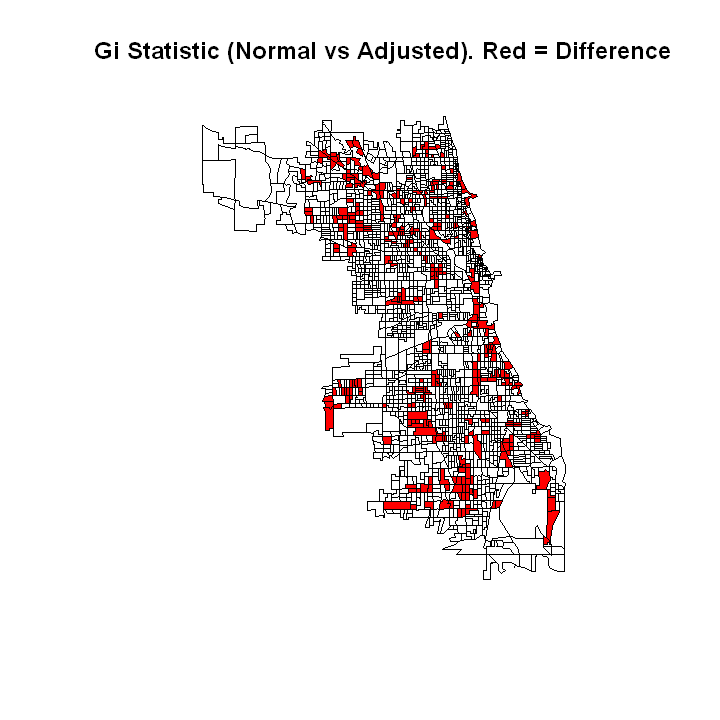

In [128]:
plot(chi.subset, col = "white", main = "Gi Statistic (Normal vs Adjusted). Red = Difference", lwd = 0.2)
plot(sub1, col = "red", add = TRUE)

For the Moran Statistic, classify the blockgroups into HH, LL, HL, and LL categories significant at the 0.95 confidence level based on the adjusted normal distribution. 

In [129]:
zAdjusted <- list()

probsU <- c(0.95)

i <- 1
for (pr in probsU){
    rmean <- mean(burgRate)
    newpr <- 1 - (((1 - pr)/ESS)/2)
    
    errorN <- qnorm(newpr, mean = rmean, lower.tail = TRUE)
    zAdjusted[[i]] <- 0 + errorN
    i <- i + 1
}

zAdjMoran <- unlist(zAdjusted)
paste(probsU, zAdjMoran, sep = " | ")

[1] "0.95 | 4.25360906212733"

In [130]:
zAdjMoran[1]

[1] 4.253609

In [131]:
Gmean <- mean(burgRate)

Gmean

[1] 0.06245429

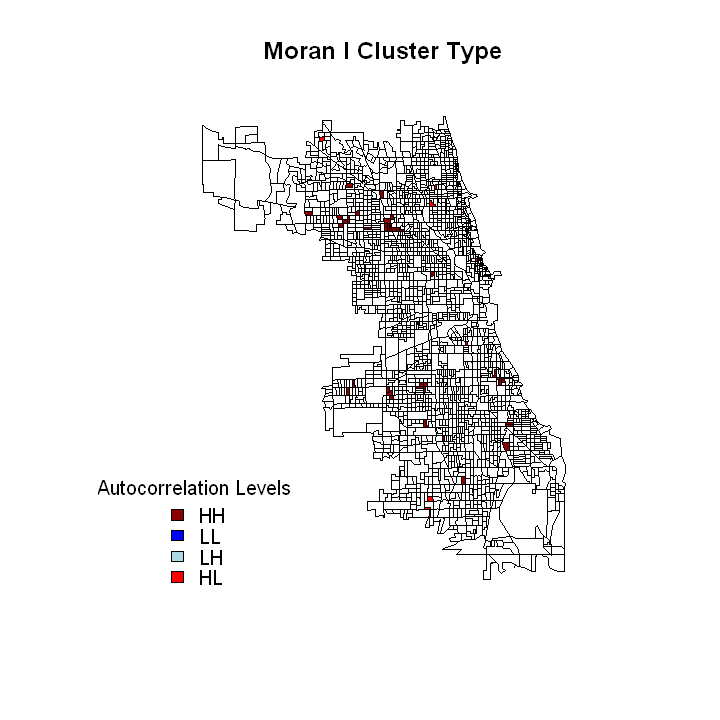

In [132]:
vlist <- list()

nid <- 1

for (ele in chi.subset.listb$neighbours){
    fee <- unlist(ele)
    ncard <- length(fee)
    
    vsum <- 0
    for (ef in fee){
        vsum <- vsum + burgRate[ef]
    }
    
    vlist[[nid]] <- vsum
    nid <- nid + 1
}

Lmean <- mean(unlist(vlist))

chi.subset$Cluster.col <- 0
chi.subset$Color.col <- 0

nid <- 1

for (ele in burgRate){
    
    if ((ele >= Gmean) && (vlist[nid] >= Lmean) && (zScore[nid] >= zAdjMoran[1])){
        chi.subset$Cluster.col[nid] <- "HH"
        chi.subset$Color.col[nid] <- "red4"
    }
    
    if ((ele <= Gmean) && (vlist[nid] <= Lmean) && (zScore[nid] <= -zAdjMoran[1])) {
        chi.subset$Cluster.col[nid] <- 'LL'
        chi.subset$Color.col[nid] <- 'blue'
    }
    
    if ((ele >= Gmean) && (vlist[nid] <= Lmean) && (zScore[nid] <= -zAdjMoran[1])) {
        chi.subset$Cluster.col[nid] <- 'HL'
        chi.subset$Color.col[nid] <- 'red'
    }   
    
    if ((ele <= Gmean) && (vlist[nid] >= Lmean) && (zScore[nid] <= -zAdjMoran[1])) {
        chi.subset$Cluster.col[nid] <- 'LH'
        chi.subset$Color.col[nid] <- 'lightblue'
    }
    
    nid <- nid + 1
}

plot(chi.subset, col = chi.subset$Color.col, lwd = 0.2, main = "Moran I Cluster Type")

legend("bottomleft", legend = c("HH", "LL", "LH", "HL"), unique(chi.subset$Cluster.col), 
              fill = c("red4", "blue", "lightblue", "red"), bty = "n", title = "Autocorrelation Levels")


For the Gi* Statistic, classify the blockgroups into HH, LL, HL, and LL categories significant at the 0.95 confidence level based on the adjusted normal distribution.

In [133]:
zAdjusted <- list()

probsU <- c(0.95)

i <- 1
for (pr in probsU){
    rmean <- mean(burgRate)
    newpr <- 1 - (((1 - pr)/ESS)/2)
    
    errorN <- qnorm(newpr, mean = rmean, lower.tail = TRUE)
    zAdjusted[[i]] <- 0 + errorN
    i <- i + 1
}

zAdjGi <- unlist(zAdjusted)
paste(probsU, zAdjGi, sep = " | ")

[1] "0.95 | 4.25360906212733"

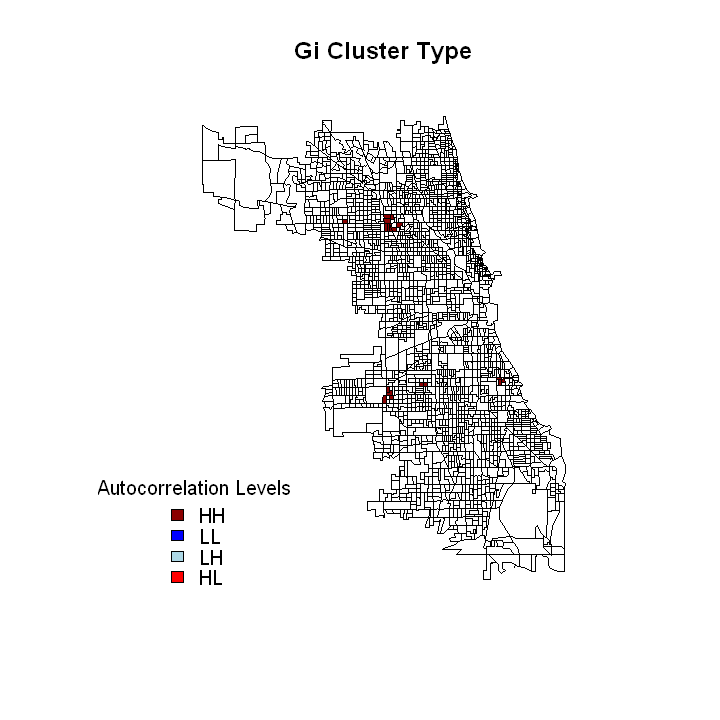

In [134]:
vlist <- list()

nid <- 1

for (ele in chi.subset.listb$neighbours){
    fee <- unlist(ele)
    ncard <- length(fee)
    
    vsum <- 0
    for (ef in fee){
        vsum <- vsum + burgRate[ef]
    }
    
    vlist[[nid]] <- vsum
    nid <- nid + 1
}

Lmean <- mean(unlist(vlist))

chi.subset$Cluster.col <- 0
chi.subset$Color.col <- 0

nid <- 1

for (ele in burgRate){
    
    if ((ele >= Gmean) && (vlist[nid] >= Lmean) && (g[nid] >= zAdjGi[1])){
        chi.subset$Cluster.col[nid] <- "HH"
        chi.subset$Color.col[nid] <- "red4"
    }
    
    if ((ele <= Gmean) && (vlist[nid] <= Lmean) && (g[nid] <= -zAdjGi[1])) {
        chi.subset$Cluster.col[nid] <- 'LL'
        chi.subset$Color.col[nid] <- 'blue'
    }
    
    if ((ele >= Gmean) && (vlist[nid] <= Lmean) && (g[nid] <= -zAdjGi[1])) {
        chi.subset$Cluster.col[nid] <- 'HL'
        chi.subset$Color.col[nid] <- 'red'
    }   
    
    if ((ele <= Gmean) && (vlist[nid] >= Lmean) && (g[nid] <= -zAdjGi[1])) {
        chi.subset$Cluster.col[nid] <- 'LH'
        chi.subset$Color.col[nid] <- 'lightblue'
    }
    
    nid <- nid + 1
}

plot(chi.subset, col = chi.subset$Color.col, lwd = 0.2, main = "Gi Cluster Type")

legend("bottomleft", legend = c("HH", "LL", "LH", "HL"), unique(chi.subset$Cluster.col), 
              fill = c("red4", "blue", "lightblue", "red"), bty = "n", title = "Autocorrelation Levels")
